In [2]:
import tvm
from tvm import relay

import numpy as np

from tvm.contrib.download import download_testdata

# PyTorch imports
import torch
import torchvision

import matplotlib.pyplot as plt

In [3]:
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets


In [4]:
torch.manual_seed(2)

In [5]:
model_name = "resnet50"
model = torchvision.models.resnet50(pretrained = True)
model = model.eval()

/home/simon/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/simon/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
train_dataset = dsets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
validation_dataset = dsets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [7]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 128, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size=128, shuffle=True)

torch.Size([128, 3, 32, 32])


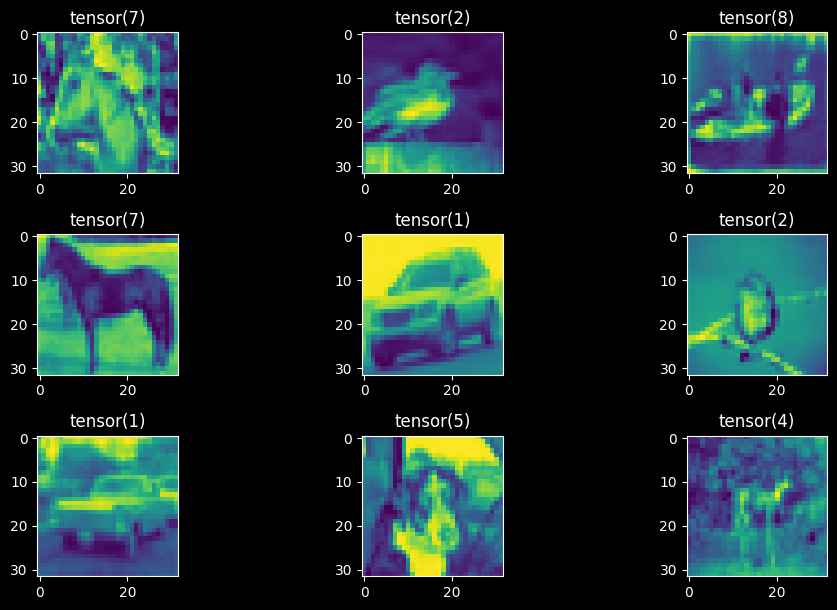

In [10]:
plt.figure(figsize=(10, 10))
for data, label in train_loader:
    for i in range(9):
        plt.subplot(5, 3, i+1)
        plt.tight_layout()
        plt.imshow(data[i][0])
        plt.title(label[i])
    plt.show()
    break

In [19]:
for data, label in train_loader:
    print(model(data))
    break

tensor([[ 2.2966,  5.3532,  7.0455,  ...,  4.1786,  0.6880,  0.7645],
        [-2.5288,  4.0828, -1.5728,  ..., -2.6961, -1.0292,  7.0304],
        [ 1.1716,  4.7839,  0.5587,  ..., -1.2551,  2.5755,  1.4108],
        ...,
        [ 2.4639,  6.7880,  4.9606,  ..., -1.2762,  2.7581,  2.6556],
        [-0.6012,  3.5464, -0.4142,  ...,  0.8947,  9.7731,  0.0198],
        [-3.8503, -0.7198, -3.8365,  ..., -0.8404,  1.0173,  2.4440]],
       grad_fn=<AddmmBackward0>)


In [11]:
model_name = "resnet50"
model = getattr(torchvision.models, model_name)(pretrained=True)
model = model.eval()

# We grab the TorchScripted model via tracing
input_shape = [128, 3, 32, 32]
input_data = torch.randn(input_shape)
scripted_model = torch.jit.trace(model, input_data).eval()

/home/simon/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/simon/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
input_name = "input0"
shape_list = [(input_name, [128, 3, 32, 32])]
mod, params = relay.frontend.from_pytorch(scripted_model, shape_list)

In [16]:
target = tvm.target.Target("llvm", host="llvm")
dev = tvm.cpu(0)
with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(mod, target=target, params=params)

One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.


In [25]:
from tvm.contrib import graph_executor

dtype = "float32"
m = graph_executor.GraphModule(lib["default"](dev))
# Set inputs
m.set_input(input_name, tvm.nd.array(img.astype(dtype)))
# Execute
m.run()
# Get outputs
tvm_output = m.get_output(0)

NameError: name 'img' is not defined

In [21]:
import torch
import numpy as np
import torchvision.models as models

import tvm
from tvm import relay
from tvm.contrib import graph_executor


In [22]:
def calibrate_dataset():
  for i in range(10):
    print("Creating {} th data".format(i))
    cal_data=np.random.random_sample((1,3,224,224)).astype('float32')
    yield {"input0": cal_data}

def check_optimize(mod,target,params):
  with tvm.transform.PassContext(opt_level=3):
    mod, params = relay.optimize(mod, params=params, target=target)
  print("<Optimized>mod "+str(mod["main"]))

In [24]:
if __name__=='__main__':
  #prepare model and input
  model = models.resnet50(pretrained=True)
  shape_list = [("input0",(1,3,224,224))]
  fake_input = torch.from_numpy(np.random.random_sample(shape_list[0][1]).astype('float32'))
  graph = torch.jit.trace(model,fake_input)
  #step 1 parse
  mod, params = relay.frontend.from_pytorch(graph, shape_list)
  target = tvm.target.Target("llvm", host="llvm")
  #step 2 quantize
  with relay.quantize.qconfig(calibrate_mode="kl_divergence", weight_scale="max"):
    mod = relay.quantize.quantize(mod, params, dataset=calibrate_dataset())

  with tvm.transform.PassContext(opt_level=3):
    lib = relay.build(mod, target=target, params=params)
  dev = tvm.cpu(0)
  m = graph_executor.GraphModule(lib["default"](dev))
  m.set_input("input0", tvm.nd.array(fake_input))
  m.run()
  res = m.get_output(0)
  print("output ",res)

/home/simon/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/simon/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Creating 0 th data
Creating 1 th data
Creating 2 th data
Creating 3 th data
Creating 4 th data
Creating 5 th data
Creating 6 th data
Creating 7 th data
Creating 8 th data
Creating 9 th data
output  [[ 6.07165337e-01  2.21732163e+00  3.79397094e-01  6.84633017e-01
   1.40127897e+00 -4.34228659e-01  2.35859871e-01 -1.88975763e+00
  -1.40370846e+00 -1.33940089e+00  6.21257067e-01  2.55380106e+00
   1.62178993e+00  1.01954663e+00  3.80963743e-01 -7.62630641e-01
   4.51769412e-01 -1.61203468e+00  3.23669642e-01  1.21473849e-01
  -1.99639201e+00 -9.58810925e-01 -9.88553345e-01 -3.32249701e-01
   2.90805817e-01  1.23039317e+00 -2.96541959e-01  3.15919757e-01
   9.15926337e-01  2.16118860e+00 -1.07892895e+00  5.57493269e-01
  -1.10765016e+00 -2.76295215e-01  3.73389900e-01 -4.36585844e-01
   1.22680569e+00 -6.95827082e-02 -1.69897902e+00 -1.76090419e+00
   4.60154891e-01 -1.02391815e+00 -1.34914383e-01 -2.39227533e+00
  -4.09638703e-01 -1.83768475e+00  6.85530305e-02 -1.34090734e+00
  -9.29796